In [1]:
from google.cloud import storage
client = storage.Client()
print("Client created using default project: {}".format(client.project))
buckets = client.list_buckets()

print("Buckets in {}:".format(client.project))
for item in buckets:
    print("\t" + item.name)
bucket = client.get_bucket('dl-bucket-upr')
print("Bucket name: {}".format(bucket.name))
print("Bucket location: {}".format(bucket.location))
print("Bucket storage class: {}".format(bucket.storage_class))

Client created using default project: dl-project-334103
Buckets in dl-project-334103:
	dl-bucket-upr
	image-ml-project
Bucket name: dl-bucket-upr
Bucket location: US
Bucket storage class: STANDARD


In [2]:
#Uncomment below code to download image and annotation files in local directory
import os
#blobs = bucket.list_blobs()
#blob_ignore = ["Annotations/","test/","train/"]
#for blob in blobs:
#    print("\t Downloading: " + blob.name)
#    if blob.name in blob_ignore:
#        print("passing blob: " + str(blob.name))
#        pass
#    else:
#        output_file_name = os.path.join("datastore/",str(blob.name))
#        blob.download_to_filename(output_file_name)
#        print("Downloaded blob {} to {}.".format(blob.name, output_file_name))

Below code to train CNN classification model

In [3]:
!pip install opencv-python

In [4]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers,optimizers
from keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import pickle              # For saving models to disk and loading saved models
import os
import zipfile
import PIL
import PIL.Image
import pathlib
import cv2 as cv2

In [5]:
# Initializing the random number generator
import random
random.seed(0)

# Ignoring the warnings
import warnings
warnings.filterwarnings("ignore")


In [6]:
path = 'datastore'
os.chdir(path)


In [7]:
!ls

 Annotations  'Car names and make.csv'	 test   train


In [25]:
#Following function to plot the epochs vs loss and epoch vs metrics graph for training and validation results
def plot_curves(history,metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize = (10,5))
    for idx,key in enumerate(metrics):
        ax = fig.add_subplot(nrows,ncols,idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train','validation'],loc='upper left')

In [43]:
df_train = pd.read_csv("Annotations/train.csv")
df_test = pd.read_csv("Annotations/test.csv")

In [44]:
df_train.sample(5)

,Image_Name,Start_x,Start_y,End_x,End_y,Image_class,Image_Path,Car_Name,Img_H,Img_W,Resize_Img_Path,Car_Type,Model,Year
4726,04727.jpg,0.014000,0.161333,0.999000,0.813333,35,/content/drive/My Drive/capstone/Dataset/Car I...,BMW M5 Sedan 2010,750,1000,/content/drive/My Drive/capstone/Car Images/tr...,Sedan,BMW,2010
1237,01238.jpg,0.086957,0.224044,0.978261,0.863388,111,/content/drive/My Drive/capstone/Dataset/Car I...,Ford Ranger SuperCab 2011,183,276,/content/drive/My Drive/capstone/Car Images/tr...,Van,Ford,2011
5717,05718.jpg,0.068333,0.117424,0.941667,0.890152,10,/content/drive/My Drive/capstone/Dataset/Car I...,Aston Martin Virage Convertible 2012,264,600,/content/drive/My Drive/capstone/Car Images/tr...,Convertible,Aston,2012
567,00568.jpg,0.070755,0.355556,0.948113,0.852778,138,/content/drive/My Drive/capstone/Dataset/Car I...,Hyundai Sonata Sedan 2012,360,424,/content/drive/My Drive/capstone/Car Images/tr...,Sedan,Hyundai,2012
1676,01677.jpg,0.057500,0.193333,0.877500,0.826667,44,/content/drive/My Drive/capstone/Dataset/Car I...,Bentley Continental Flying Spur Sedan 2007,300,400,/content/drive/My Drive/capstone/Car Images/tr...,Sedan,Bentley,2007


In [136]:
img_path = "train/"
df_train['Image_Path'] = df_train['Image_Name'].apply(lambda x:os.path.join(img_path,x))
img_path = "resize/"
df_train['Resize_Img_Path'] = df_train['Image_Name'].apply(lambda x:os.path.join(img_path,x))
df_train.sample(5)

,Image_Name,Start_x,Start_y,End_x,End_y,Image_class,Image_Path,Car_Name,Img_H,Img_W,Resize_Img_Path,Car_Type,Model,Year
304,00305.jpg,0.185000,0.156716,0.845000,0.910448,143,train/00305.jpg,Isuzu Ascender SUV 2008,134,200,resize/00305.jpg,SUV,Isuzu,2008
8053,08054.jpg,0.053819,0.201705,0.939236,0.806818,117,train/08054.jpg,Ford Fiesta Sedan 2012,352,576,resize/08054.jpg,Sedan,Ford,2012
178,00179.jpg,0.065625,0.235417,0.939063,0.914583,155,train/00179.jpg,Land Rover LR2 SUV 2012,480,640,resize/00179.jpg,SUV,Land,2012
1570,01571.jpg,0.075000,0.250000,0.920312,0.772917,172,train/01571.jpg,Plymouth Neon Coupe 1999,480,640,resize/01571.jpg,Coupe,Plymouth,1999
3057,03058.jpg,0.068750,0.079167,0.856250,0.964583,98,train/03058.jpg,Eagle Talon Hatchback 1998,480,640,resize/03058.jpg,Hatchback,Eagle,1998


In [138]:
img_path = "test/"
df_test['Image_Path'] = df_test['Image_Name'].apply(lambda x:os.path.join(img_path,x))
img_path = "resize_test/"
df_test['Resize_Img_Path'] = df_test['Image_Name'].apply(lambda x:os.path.join(img_path,x))
df_test.sample(5)

,Image_Name,Start_x,Start_y,End_x,End_y,Image_class,Image_Path,Car_Name,Img_H,Img_W,Resize_Img_Path,Car_Type,Model,Year
7007,07008.jpg,0.026562,0.285417,0.832812,0.625000,173,test/07008.jpg,Porsche Panamera Sedan 2012,480,640,resize_test/07008.jpg,Sedan,Porsche,2012
2481,02482.jpg,0.079167,0.316667,0.925000,0.933333,74,test/02482.jpg,Chevrolet Silverado 1500 Extended Cab 2012,360,480,resize_test/02482.jpg,Van,Chevrolet,2012
4256,04257.jpg,0.204167,0.130556,0.931250,0.805556,121,test/04257.jpg,GMC Acadia SUV 2012,360,480,resize_test/04257.jpg,SUV,GMC,2012
5535,05536.jpg,0.075000,0.275000,0.921875,0.887500,159,test/05536.jpg,Mazda Tribute SUV 2011,240,320,resize_test/05536.jpg,SUV,Mazda,2011
8006,08007.jpg,0.065625,0.335417,0.976562,0.962500,119,test/08007.jpg,GMC Savana Van 2012,480,640,resize_test/08007.jpg,Van,GMC,2012


In [47]:
df_car_name = pd.read_csv("Car names and make.csv",names=['Car Name'])
df_car_name

,Car Name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007


In [48]:
count = 0
car_dict = {}
for car_name in df_car_name['Car Name'].values:
    car_dict[count+1] = car_name
    count=count+1
car_dict

{1: 'AM General Hummer SUV 2000',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura Integra Type R 2001',
 7: 'Acura ZDX Hatchback 2012',
 8: 'Aston Martin V8 Vantage Convertible 2012',
 9: 'Aston Martin V8 Vantage Coupe 2012',
 10: 'Aston Martin Virage Convertible 2012',
 11: 'Aston Martin Virage Coupe 2012',
 12: 'Audi RS 4 Convertible 2008',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi TTS Coupe 2012',
 15: 'Audi R8 Coupe 2012',
 16: 'Audi V8 Sedan 1994',
 17: 'Audi 100 Sedan 1994',
 18: 'Audi 100 Wagon 1994',
 19: 'Audi TT Hatchback 2011',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi S5 Convertible 2012',
 22: 'Audi S5 Coupe 2012',
 23: 'Audi S4 Sedan 2012',
 24: 'Audi S4 Sedan 2007',
 25: 'Audi TT RS Coupe 2012',
 26: 'BMW ActiveHybrid 5 Sedan 2012',
 27: 'BMW 1 Series Convertible 2012',
 28: 'BMW 1 Series Coupe 2012',
 29: 'BMW 3 Series Sedan 2012',
 30: 'BMW 3 Series Wagon 2012',
 31: 'BMW 6 Series Convertible 2007',
 32: 

In [49]:
car_names = list(df_car_name['Car Name'].values)
car_types = []
car_year = []
car_model = []
for cars in car_names:
    carname = cars.split(' ')
    model_word_length = len(carname) - 3 #Remove 1 each for name od car company, type of car and model year
    car_types.append(carname[len(carname)-2])
    car_year.append(carname[len(carname)-1])
    car_model.append(carname[0])

df_car_name['Car_Type'] = car_types
df_car_name['Model'] = car_model
df_car_name['Year'] = car_year
df_car_name.sample(10)

,Car Name,Car_Type,Model,Year
10,Aston Martin Virage Coupe 2012,Coupe,Aston,2012
17,Audi 100 Wagon 1994,Wagon,Audi,1994
116,Ford Fiesta Sedan 2012,Sedan,Ford,2012
173,Ram C/V Cargo Van Minivan 2012,Minivan,Ram,2012
53,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,Cab,Chevrolet,2012
92,Dodge Challenger SRT8 2011,SRT8,Dodge,2011
177,Scion xD Hatchback 2012,Hatchback,Scion,2012
100,Ferrari FF Coupe 2012,Coupe,Ferrari,2012
71,Chevrolet Monte Carlo Coupe 2007,Coupe,Chevrolet,2007
26,BMW 1 Series Convertible 2012,Convertible,BMW,2012


In [50]:
Sedan = ['Sedan','GS','Type-S','SRT-8']
Hatchback = ['Hatchback','Abarth']
Coupe = ['Coupe','IPL','XKR','Z06','ZR1','R','SRT8','Superleggera']
SUV = ['SUV','SS']
Van = ['Van','Minivan','Wagon','Cab','SuperCab']
df_car_name['Car_Type'].replace(to_replace=Sedan,value='Sedan',inplace=True) 
df_car_name['Car_Type'].replace(to_replace=Hatchback,value='Hatchback',inplace=True) 
df_car_name['Car_Type'].replace(to_replace=Coupe,value='Coupe',inplace=True)
df_car_name['Car_Type'].replace(to_replace=SUV,value='SUV',inplace=True)
df_car_name['Car_Type'].replace(to_replace=Van,value='Van',inplace=True)
df_car_name.sample(5)

,Car Name,Car_Type,Model,Year
75,Chrysler Aspen SUV 2009,SUV,Chrysler,2009
52,Cadillac Escalade EXT Crew Cab 2007,Van,Cadillac,2007
96,Dodge Charger SRT-8 2009,Sedan,Dodge,2009
22,Audi S4 Sedan 2012,Sedan,Audi,2012
174,Rolls-Royce Phantom Drophead Coupe Convertible...,Convertible,Rolls-Royce,2012


In [51]:
df_visualize = df_train[['Image_Path','Car_Name','Start_x','Start_y','End_x','End_y']].sample(10)

In [52]:
df_visualize['Bbox'] = df_visualize.apply(lambda x:list([float(x['Start_x']),float(x['Start_y']),float(x['End_x']),float(x['End_y'])]),axis=1)
df_visualize

,Image_Path,Car_Name,Start_x,Start_y,End_x,End_y,Bbox
862,train/00863.jpg,Chrysler Sebring Convertible 2010,0.040625,0.204167,0.973437,0.897917,"[0.040625, 0.2041666666666666, 0.9734375, 0.89..."
2936,train/02937.jpg,Scion xD Hatchback 2012,0.003215,0.386139,0.737942,0.946535,"[0.0032154340836012, 0.3861386138613861, 0.737..."
1179,train/01180.jpg,Audi V8 Sedan 1994,0.036667,0.128889,0.980000,0.822222,"[0.0366666666666666, 0.1288888888888889, 0.98,..."
4850,train/04851.jpg,Hyundai Elantra Sedan 2007,0.101562,0.139583,0.907813,0.854167,"[0.1015625, 0.1395833333333333, 0.9078125, 0.8..."
1918,train/01919.jpg,BMW M6 Convertible 2010,0.040625,0.277083,0.965625,0.722917,"[0.040625, 0.2770833333333333, 0.965625, 0.722..."
7070,train/07071.jpg,Geo Metro Convertible 1993,0.101562,0.237647,0.910937,0.840000,"[0.1015625, 0.2376470588235294, 0.9109375, 0.84]"
182,train/00183.jpg,Mercedes-Benz 300-Class Convertible 1993,0.010000,0.060000,0.980000,0.833333,"[0.01, 0.06, 0.98, 0.8333333333333334]"
6529,train/06530.jpg,Aston Martin V8 Vantage Convertible 2012,0.176471,0.268382,0.774510,0.797794,"[0.1764705882352941, 0.2683823529411765, 0.774..."
3408,train/03409.jpg,Jaguar XK XKR 2012,0.056250,0.383099,0.943750,0.813146,"[0.05625, 0.3830985915492957, 0.94375, 0.81314..."
4500,train/04501.jpg,Toyota Sequoia SUV 2012,0.060417,0.066667,0.972917,0.930556,"[0.0604166666666666, 0.0666666666666666, 0.972..."


In [53]:
image_list = list(df_visualize['Image_Path'])
class_list = list(df_visualize['Car_Name'])
bbox_list = list(df_visualize['Bbox'])

In [54]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (0, 0, 0) # White
#img_path = "/content/drive/My Drive/capstone/Car Images/train_img_300_resized/"

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int,bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, (y_min - int(0.3 * text_height))), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image_list, bbox_list, class_list):
    count = 0
    image_final = []
    for image_name in image_list:
        print(image_name)
        #filename = os.path.join(img_path,image_name)
        #print(filename)
        image = cv2.imread(image_name,cv2.COLOR_BGR2RGB)
        #print(image)
        img = image.copy()
        h,w,_ = img.shape
        #img = (cv.resize(img,(224,224)))
        #print(img)
        bbox = bbox_list[count]
        bbox[0] = bbox[0]*w
        bbox[1] = bbox[1]*h
        bbox[2] = bbox[2]*w
        bbox[3] = bbox[3]*h
        #print(bbox)
        class_name = class_list[count]
        #print(class_name)
        img = visualize_bbox(img, bbox, class_name)
        image_final.append(img)
        count = count + 1
    #plt.figure(figsize=(50, 50))
    fig, axs = plt.subplots(int(count), 1,figsize=(70, 70))
    axs = axs.flatten()
    for img,ax in zip(image_final,axs):
        ax.imshow(img)
    plt.show()

train/01612.jpg
train/07410.jpg
train/03684.jpg
train/06954.jpg
train/05233.jpg
train/06738.jpg
train/03677.jpg
train/02064.jpg
train/07301.jpg
train/01952.jpg


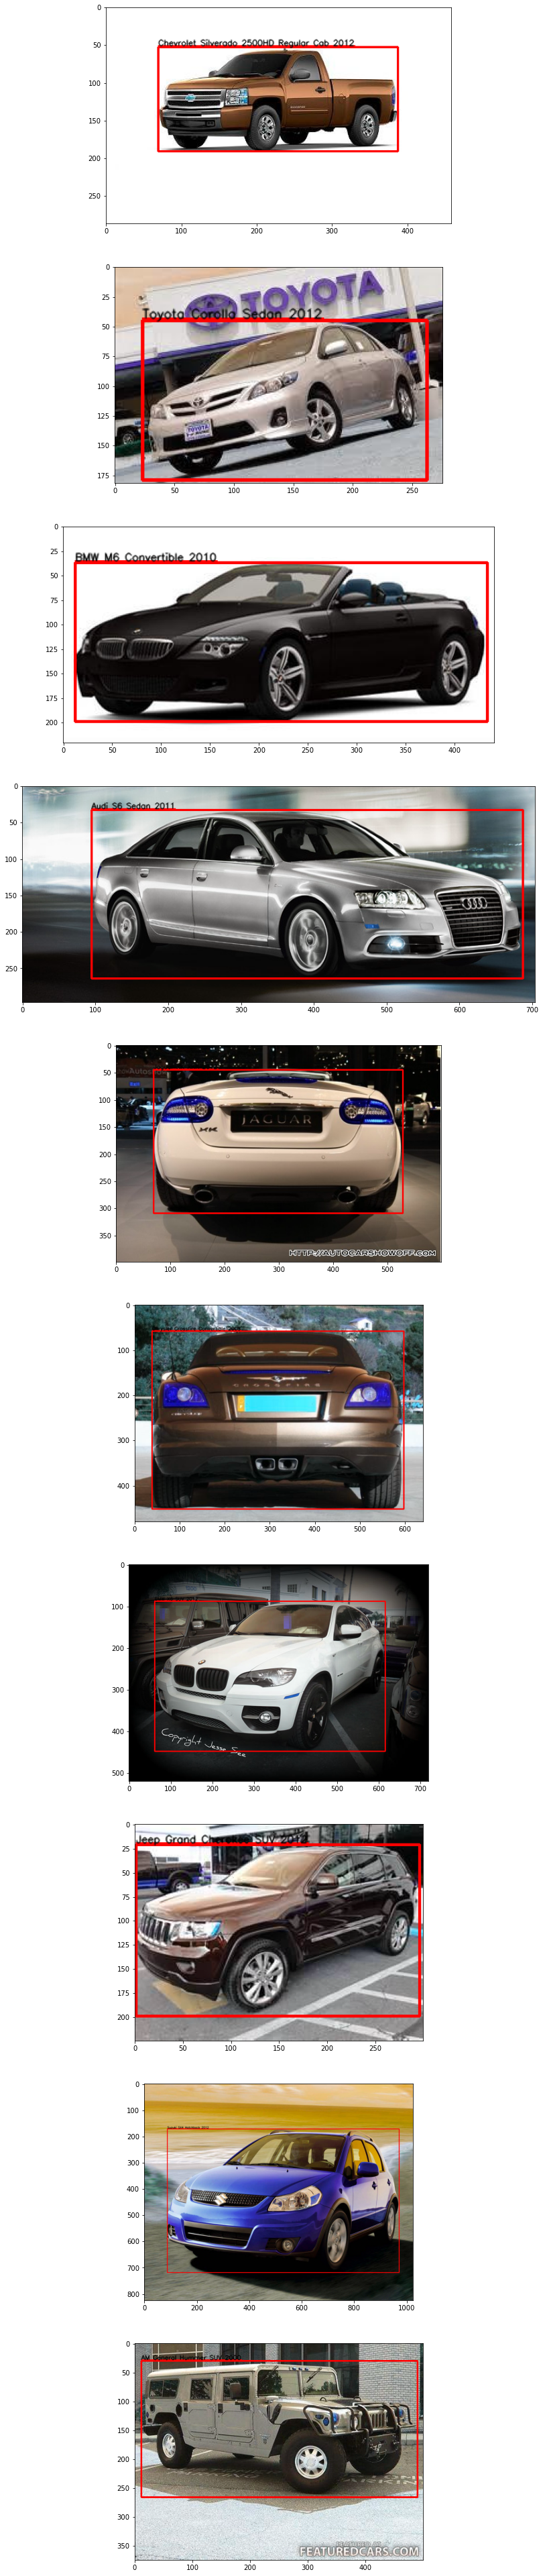

In [20]:
visualize(image_list,bbox_list,class_list)

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
test_datagen  = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(df_train,directory=None, x_col='Image_Path', y_col='Car_Type',subset="training",weight_col=None,target_size=(300,300),color_mode='rgb',class_mode='categorical',batch_size=32,shuffle=True)
valid_generator = train_datagen.flow_from_dataframe(df_train,directory=None, x_col='Image_Path', y_col='Car_Type',subset="validation",weight_col=None,target_size=(300,300),color_mode='rgb',class_mode='categorical',batch_size=32,shuffle=True)
test_generator = train_datagen.flow_from_dataframe(df_test,directory=None, x_col='Image_Path', y_col=None,weight_col=None,target_size=(300,300),color_mode='rgb',class_mode=None,batch_size=32,shuffle=False)

Found 6108 validated image filenames belonging to 6 classes.
Found 2036 validated image filenames belonging to 6 classes.
Found 8041 validated image filenames.


In [22]:
class_label_map = train_generator.class_indices
class_label_map

{'Convertible': 0, 'Coupe': 1, 'Hatchback': 2, 'SUV': 3, 'Sedan': 4, 'Van': 5}

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(300,300,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))
model.compile(optimizers.RMSprop(learning_rate=0.001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 300, 300, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 298, 298, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 298, 298, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 149, 149, 32)      0         
                                                      

In [30]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
H = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
190/190 [==============================] - 95s 496ms/step - loss: 1.9670 - accuracy: 0.2424 - val_loss: 1.8026 - val_accuracy: 0.2639
Epoch 2/10
190/190 [==============================] - 94s 493ms/step - loss: 1.6883 - accuracy: 0.2823 - val_loss: 1.6797 - val_accuracy: 0.3051
Epoch 3/10
190/190 [==============================] - 93s 491ms/step - loss: 1.6305 - accuracy: 0.3232 - val_loss: 1.6347 - val_accuracy: 0.3313
Epoch 4/10
190/190 [==============================] - 93s 488ms/step - loss: 1.5530 - accuracy: 0.3590 - val_loss: 1.6370 - val_accuracy: 0.3204
Epoch 5/10
190/190 [==============================] - 94s 494ms/step - loss: 1.4551 - accuracy: 0.4166 - val_loss: 1.6920 - val_accuracy: 0.3189
Epoch 6/10
190/190 [==============================] - 94s 496ms/step - loss: 1.3252 - accuracy: 0.4735 - val_loss: 1.6865 - val_accuracy: 0.3244
Epoch 7/10
190/190 [==============================] - 93s 490ms/step - loss: 1.1603 - accuracy: 0.5486 - val_loss: 1.7754 - val_ac

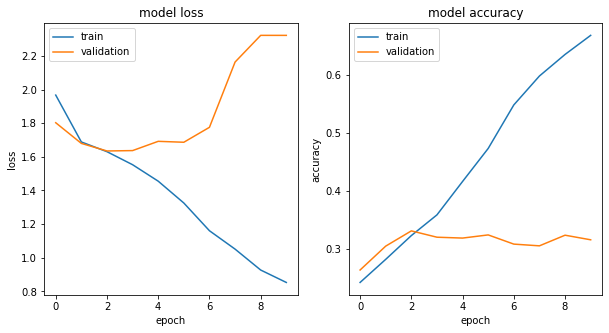

In [31]:
plot_curves(H,['loss','accuracy'])

In [112]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=[0.2,1.5],
                                   validation_split=0.20)
test_datagen  = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(df_train,directory=None,
                                                    x_col='Image_Path',
                                                    y_col='Car_Type',
                                                    subset="training",
                                                    weight_col=None,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

valid_generator = train_datagen.flow_from_dataframe(df_train,directory=None,
                                                    x_col='Image_Path',
                                                    y_col='Car_Type',
                                                    subset="validation",
                                                    weight_col=None,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

test_generator = test_datagen.flow_from_dataframe(df_test,directory=None,
                                                  x_col='Image_Path',
                                                  y_col=None,
                                                  weight_col=None,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode=None,
                                                  batch_size=32,
                                                  shuffle=False)

Found 6516 validated image filenames belonging to 6 classes.
Found 1628 validated image filenames belonging to 6 classes.
Found 8041 validated image filenames.


In [113]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [104]:
#!pip install tensorflow_model_optimization

In [114]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer head, this one to predict
# the class label
#softmaxHead = Dense(64, activation="relu")(flatten)
#softmaxHead = Dropout(0.25)(softmaxHead)
#softmaxHead = Dense(64, activation="relu")(softmaxHead)
#softmaxHead = Dropout(0.25)(softmaxHead)
#softmaxHead = Dense(32, activation="relu")(softmaxHead)
#softmaxHead = Dropout(0.25)(softmaxHead)
#softmaxHead = Dense(196, activation="softmax",name="class_label")(softmaxHead)
softmaxHead = Dense(6, activation="softmax",name="class_label")(flatten)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input,outputs=[softmaxHead])

In [106]:
import tensorflow_model_optimization as tfmot
model = tfmot.quantization.keras.quantize_model(model)

In [115]:
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [121]:
import datetime
import os
%reload_ext tensorboard

In [117]:
logdir = os.path.join("logdir",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10, mode='auto',restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
             early_stopping,
             tensorboard_callback
]

In [123]:
%tensorboard --logdir logdir

Reusing TensorBoard on port 6006 (pid 1501), started 0:00:43 ago. (Use '!kill 1501' to kill it.)

In [120]:
print("[INFO] training model...")
H = model.fit_generator(train_generator,
                        validation_data=valid_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=NUM_EPOCHS,
                        callbacks = callbacks,
                        verbose=1)

[INFO] training model...
Epoch 1/10
203/203 [==============================] - 149s 735ms/step - loss: 1.8756 - accuracy: 0.3049 - val_loss: 1.8154 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 2/10
203/203 [==============================] - 147s 723ms/step - loss: 1.8153 - accuracy: 0.3580 - val_loss: 1.7462 - val_accuracy: 0.3819 - lr: 0.0010
Epoch 3/10
203/203 [==============================] - 149s 733ms/step - loss: 1.7428 - accuracy: 0.3795 - val_loss: 1.6594 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 4/10
203/203 [==============================] - 150s 738ms/step - loss: 1.6978 - accuracy: 0.3950 - val_loss: 1.6859 - val_accuracy: 0.3825 - lr: 0.0010
Epoch 5/10
203/203 [==============================] - 152s 750ms/step - loss: 1.7591 - accuracy: 0.3893 - val_loss: 1.8783 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/10
203/203 [==============================] - 152s 751ms/step - loss: 1.7298 - accuracy: 0.4129 - val_loss: 1.7164 - val_accuracy: 0.3887 - lr: 0.0010
Epoch 7/10
203/203 [=

In [125]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
                 name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(64, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(32, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(6, activation="softmax",
                    name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [127]:
INIT_LR = 1e-3
NUM_EPOCHS = 20
BATCH_SIZE = 32
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

In [128]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.20)
test_datagen  = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(df_train,directory=None,
                                                    x_col='Image_Path',
                                                    y_col='Car_Type',
                                                    subset="training",
                                                    weight_col=None,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

valid_generator = train_datagen.flow_from_dataframe(df_train,directory=None,
                                                    x_col='Image_Path',
                                                    y_col='Car_Type',
                                                    subset="validation",
                                                    weight_col=None,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

test_generator = test_datagen.flow_from_dataframe(df_test,directory=None,
                                                  x_col='Image_Path',
                                                  y_col=None,
                                                  weight_col=None,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode=None,
                                                  batch_size=32,
                                                  shuffle=False)

Found 6516 validated image filenames belonging to 6 classes.
Found 1628 validated image filenames belonging to 6 classes.
Found 8041 validated image filenames.


In [129]:
X=[]
y=[]
train_generator.reset()
for i in range(train_generator.__len__()):
    a,b=train_generator.next()
    X.append(a)
    y.append(b)

#Below code to concat multiple arrays vertically
X_array = np.vstack([X[i] for i in range(len(X))])

y_array = np.vstack([y[i] for i in range(len(y))])

In [130]:
X_array.shape

(6516, 224, 224, 3)

In [131]:
X=[]
y=[]
valid_generator.reset()
for i in range(valid_generator.__len__()):
    a,b=valid_generator.next()
    X.append(a)
    y.append(b)

#Below code to concat multiple arrays vertically
X_val = np.vstack([X[i] for i in range(len(X))])

y_val = np.vstack([y[i] for i in range(len(y))])

In [132]:
X_val.shape

(1628, 224, 224, 3)

In [133]:
X=[]
test_generator.reset()
for i in range(test_generator.__len__()):
    a=test_generator.next()
    X.append(a)

#Below code to concat multiple arrays vertically
X_test = np.vstack([X[i] for i in range(len(X))])

MemoryError: Unable to allocate 4.51 GiB for an array with shape (8041, 224, 224, 3) and data type float32

In [137]:
def resize_image(image_list,resize_path,image_size=224):
    for img in image_list:
        im = cv2.imread(img,cv2.COLOR_BGR2RGB)
        old_size = im.shape[:2]  # old_size is in (height, width) format
        ratio = float(image_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        # new_size should be in (width, height) format
        im = cv2.resize(im, (new_size[1], new_size[0]))
        delta_w = image_size - new_size[1]
        delta_h = image_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                    value=color)
        print(new_im.shape)
        img_path = img.split('/')
        resize_path = os.path.join(resize_path,img_path[-1])
        cv2.imwrite(resize_path, new_im)
        cv2.waitKey(0)
        #cv2.destroyAllWindows()
#img_list = list(df_train["Image_Path"])
#resize_image(img_list,"resize/")
img_list = list(df_test["Image_Path"])
resize_image(img_list,"resize_test/")        

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224

In [139]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=[0.2,1.5],
                                   validation_split=0.20)
test_datagen  = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(df_train,directory=None,
                                                    x_col='Resize_Img_Path',
                                                    y_col='Car_Type',
                                                    subset="training",
                                                    weight_col=None,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

valid_generator = train_datagen.flow_from_dataframe(df_train,directory=None,
                                                    x_col='Resize_Img_Path',
                                                    y_col='Car_Type',
                                                    subset="validation",
                                                    weight_col=None,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True)

test_generator = test_datagen.flow_from_dataframe(df_test,directory=None,
                                                  x_col='Resize_Img_Path',
                                                  y_col=None,
                                                  weight_col=None,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode=None,
                                                  batch_size=32,
                                                  shuffle=False)

Found 6516 validated image filenames belonging to 6 classes.
Found 1628 validated image filenames belonging to 6 classes.
Found 1 validated image filenames.


In [140]:
NUM_EPOCHS = 20
BATCH_SIZE = 32
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [141]:
def get_model():
    # load the VGG16 network, ensuring the head FC layers are left off
    vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
    # freeze all VGG layers so they will *not* be updated during the
    # training process
    vgg.trainable = False
    # flatten the max-pooling output of VGG
    flatten = vgg.output
    flatten = Flatten()(flatten)
    softmaxHead = Dense(6, activation="softmax",name="class_label")(flatten)
    # put together our model which accept an input image and then output
    # bounding box coordinates and a class label
    model = Model(inputs=vgg.input,outputs=[softmaxHead])
    
    return model

model = get_model()

In [142]:
opt = Adam(lr=0.005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [143]:
import datetime
import os
%reload_ext tensorboard

In [144]:
logdir = os.path.join("logdir",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10, mode='auto',restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
    early_stopping,
    tensorboard_callback
    ]

In [147]:
#!kill 1501

In [150]:
%tensorboard --logdir logdir

Reusing TensorBoard on port 6006 (pid 1501), started 1:37:17 ago. (Use '!kill 1501' to kill it.)

In [149]:
print("[INFO] training model...")
H = model.fit_generator(train_generator,
                        validation_data=valid_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=NUM_EPOCHS,
                        callbacks = callbacks,
                        verbose=1)

[INFO] training model...
Epoch 1/20
203/203 [==============================] - 182s 890ms/step - loss: 4.2767 - accuracy: 0.2770 - val_loss: 3.2941 - val_accuracy: 0.2900 - lr: 0.0050
Epoch 2/20
203/203 [==============================] - 188s 924ms/step - loss: 3.9777 - accuracy: 0.3109 - val_loss: 4.0505 - val_accuracy: 0.2950 - lr: 0.0050
Epoch 3/20
203/203 [==============================] - 177s 871ms/step - loss: 4.6174 - accuracy: 0.3176 - val_loss: 4.0956 - val_accuracy: 0.3494 - lr: 0.0050
Epoch 4/20
203/203 [==============================] - 178s 875ms/step - loss: 4.3352 - accuracy: 0.3399 - val_loss: 4.0690 - val_accuracy: 0.3462 - lr: 0.0050
Epoch 5/20
203/203 [==============================] - 177s 869ms/step - loss: 4.7397 - accuracy: 0.3370 - val_loss: 4.3264 - val_accuracy: 0.3375 - lr: 0.0050
Epoch 6/20
203/203 [==============================] - 179s 882ms/step - loss: 4.7400 - accuracy: 0.3509 - val_loss: 4.0218 - val_accuracy: 0.3594 - lr: 0.0050
Epoch 7/20
203/203 [=